# Enigma - CDL Hackathon - Trip Generator





In [1]:
import networkx as nx
from collections import defaultdict
from dimod import BinaryQuadraticModel
from tabu import TabuSampler        
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
import neal
from strawberryfields.apps import plot
import plotly
import numpy as np
import csv
from flightHelper import *

## Controls


In [2]:
# Solver selection. Default is Tabu when all set to False
    
useQPU = False
useNeal = False
useHyb = True

# Prepare the problem specific home base constraints

#targetDataSet="DS2b.csv"
targetDataSet="" # Use the default data set from within
HomeBases = { "LCA" : 1 }

# Set up the home base biases 

NotHomeBaseWeight = makeBaseWeight(len(HomeBases)+1) 

# Constraint and objectives switches

cons_1c_on = True  # Enforce 1 node per row
cons_2_on = True   # Enforce node used only once
cons_3_on = True   # At least one Start flag per result
cons_4_on = True   # Only connections allowed by edges
cons_5_on = True   # Return to start location

objective_1_on = True # Establish baseline unallocated time
objective_2_on = True # Replace unallocated time with CI, CO, gap

LagrangeA = makeBaseWeight(len(HomeBases)+1)    # Order of magnitude for constraints -> Should be bigger than the base constraints magnitude
LagrangeB = LagrangeA / 10                       # Order of magnitude for allowed edges
LagrangeC = 1                                    # order of magnitude for return to start location (uses base weights)

In [3]:
def buildSet1():
    segments=[]
    segments.append( Node(Segment(1, "101", "LCA", "ATH", 600, 695, 1, 1,HomeBases)))
    segments.append( Node(Segment(2, "102", "ATH", "LCA", 755, 845, 1, 1,HomeBases)))
    segments.append( Node(Segment(3, "103", "LCA", "ATH", 875, 970, 1, 1,HomeBases)))
    segments.append( Node(Segment(4, "104", "ATH", "LCA", 1035, 1125, 1, 1,HomeBases)))
    return(segments)

# Load data from files or use the default data set 1

#segments = loadFlts("DS1.csv", ["320"], HomeBases )
if ( targetDataSet != "" ):
    segments = loadFlts(targetDataSet, Atypes=[], depDay = 1, HomeBases=HomeBases )
else:
    segments = buildSet1()

for s in segments:
    print(s.obj.__dict__)

{'id': 1, 'lab': '101', 'dep': 'LCA', 'arr': 'ATH', 'deptime': 600, 'arrtime': 695, 'depday': 1, 'arrday': 1, 'ft': 95, 'UT1': 0, 'UT2': 0, 'T': 0, 'ci': 0, 'co': 0, 'DepBaseWgt': 1000000, 'ArrBaseWgt': 0}
{'id': 2, 'lab': '102', 'dep': 'ATH', 'arr': 'LCA', 'deptime': 755, 'arrtime': 845, 'depday': 1, 'arrday': 1, 'ft': 90, 'UT1': 0, 'UT2': 0, 'T': 0, 'ci': 0, 'co': 0, 'DepBaseWgt': 0, 'ArrBaseWgt': 1000000}
{'id': 3, 'lab': '103', 'dep': 'LCA', 'arr': 'ATH', 'deptime': 875, 'arrtime': 970, 'depday': 1, 'arrday': 1, 'ft': 95, 'UT1': 0, 'UT2': 0, 'T': 0, 'ci': 0, 'co': 0, 'DepBaseWgt': 1000000, 'ArrBaseWgt': 0}
{'id': 4, 'lab': '104', 'dep': 'ATH', 'arr': 'LCA', 'deptime': 1035, 'arrtime': 1125, 'depday': 1, 'arrday': 1, 'ft': 90, 'UT1': 0, 'UT2': 0, 'T': 0, 'ci': 0, 'co': 0, 'DepBaseWgt': 0, 'ArrBaseWgt': 1000000}


In [4]:



def buildSet2():
    segments=[]
    segments.append( Node(Segment(1, '2450', 'HOT', 'ELD', 425, 465, 1, 1,HomeBases)))
    segments.append( Node(Segment(6, '2450', 'ELD', 'IAH', 485, 595, 1, 1,HomeBases)))
    segments.append( Node(Segment(11, '2451', 'IAH', 'ELD', 625, 740, 1, 1,HomeBases)))
    segments.append( Node(Segment(16, '2451', 'ELD', 'HOT', 755, 795, 1, 1,HomeBases)))
    segments.append( Node(Segment(21, '2452', 'HOT', 'ELD', 850, 890, 1, 1,HomeBases)))
    segments.append( Node(Segment(26, '2452', 'ELD', 'IAH', 905, 1015, 1, 1,HomeBases)))
    segments.append( Node(Segment(31, '2453', 'IAH', 'ELD', 1050, 1160, 1, 1,HomeBases)))
    segments.append( Node(Segment(36, '2453', 'ELD', 'HOT', 1175, 1215, 1, 1,HomeBases)))
    segments.append( Node(Segment(41, '2454', 'HOT', 'MEM', 810, 890, 1, 1,HomeBases)))
    segments.append( Node(Segment(46, '2455', 'MEM', 'HOT', 750, 830, 1, 1,HomeBases)))
    segments.append( Node(Segment(51, '2456', 'HOT', 'MEM', 1230, 1310, 1, 1,HomeBases)))
    segments.append( Node(Segment(56, '2457', 'MEM', 'HOT', 330, 410, 1, 1,HomeBases)))
    segments.append( Node(Segment(136, '4125', 'MEM', 'HRO', 920, 1005, 1, 1,HomeBases)))
    segments.append( Node(Segment(142, '4126', 'HRO', 'MEM', 1030, 1110, 1, 1,HomeBases)))
    segments.append( Node(Segment(148, '4127', 'MEM', 'HRO', 500, 585, 1, 1,HomeBases)))
    segments.append( Node(Segment(153, '4128', 'HRO', 'MEM', 615, 695, 1, 1,HomeBases)))
    segments.append( Node(Segment(158, '4311', 'HRO', 'MEM', 390, 470, 1, 1,HomeBases)))
    segments.append( Node(Segment(164, '4311', 'HRO', 'MEM', 390, 470, 1, 1,HomeBases)))
    segments.append( Node(Segment(169, '4311', 'HRO', 'MEM', 390, 470, 1, 1,HomeBases)))
    segments.append( Node(Segment(175, '4316', 'MEM', 'HRO', 1135, 1220, 1, 1,HomeBases)))
    return(segments)

def buildSet3():
    segments=[]
    segments.append( Node(Segment(73, '3312', 'PDX', 'PDT', 420, 500, 1, 1,HomeBases)))
    segments.append( Node(Segment(78, '3314', 'PDX', 'PDT', 635, 715, 1, 1,HomeBases)))
    segments.append( Node(Segment(83, '3316', 'PDX', 'PDT', 920, 1000, 1, 1,HomeBases)))
    segments.append( Node(Segment(88, '3318', 'PDX', 'PDT', 1135, 1215, 1, 1,HomeBases)))
    segments.append( Node(Segment(97, '3318', 'PDX', 'PDT', 1135, 1215, 1, 1,HomeBases)))
    segments.append( Node(Segment(103, '3321', 'PDT', 'PDX', 315, 395, 1, 1,HomeBases)))
    segments.append( Node(Segment(108, '3323', 'PDT', 'PDX', 525, 605, 1, 1,HomeBases)))
    segments.append( Node(Segment(113, '3325', 'PDT', 'PDX', 740, 820, 1, 1,HomeBases)))
    segments.append( Node(Segment(118, '3327', 'PDT', 'PDX', 1025, 1105, 1, 1,HomeBases)))
    segments.append( Node(Segment(126, '3327', 'PDT', 'PDX', 1025, 1105, 1, 1,HomeBases)))
    return(segments)


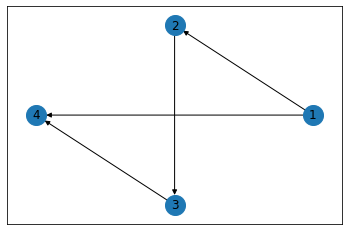

In [5]:
def buildViewGraph(segments):
    G = nx.DiGraph()
    for n1 in segments:
        for n2 in segments:
            if ( n1.id != n2.id ):
                # Prevent connections when gaps are 0 or negative
                cw = ConnectWeight(n1.obj,n2.obj)
                if ( cw.gap > 0 ):
                    G.add_weighted_edges_from([(n1.id,n2.id, cw.gap  )])
    return G

def buildFltGraph(segments):
    G = nx.DiGraph()
    for n1 in segments:
        for n2 in segments:
            if ( n1.id != n2.id ):
                # Prevent connections when gaps are 0 or negative
                cw = ConnectWeight(n1.obj,n2.obj)
                if ( cw.gap > 0 ):
                    G.add_weighted_edges_from([(n1,n2, cw  )])
    return G

#segments = buildSet1()
G1 = buildViewGraph(segments)
#G2 = buildViewGraph(buildSet2())
#G3 = buildViewGraph(buildSet3())

pos = nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos, node_size=400 , alpha=1)

#pos = nx.kamada_kawai_layout(G2)
#nx.draw_networkx(G2, pos=pos, node_size=400 , alpha=1)

#pos = nx.circular_layout(G3)
#nx.draw_networkx(G3, pos=pos, node_size=400 , alpha=1)

#plot.graph(G2) #Example with G2


In [6]:
G = buildFltGraph(segments)

# Init the number of segment Nodes

N = len(segments)

# T is the time range encompassing all segments 

print ("Minimum Dep", min(node.obj.deptime + ((node.obj.depday-1)) * 1440 for node in segments))
print ("Maximum Arr", max(node.obj.arrtime + ((node.obj.arrday-1)) * 1440 for node in segments))

T = max(node.obj.getUarrtime() for node in segments) + (2 * 1440) # We add buffer of 1 day prior and 1 day after

print ( "T is ", T)

for seg in segments:
    seg.obj.setT(T)
    seg.obj.setCI(60) # Checkin Time TODO: Parameterize this
    seg.obj.setCO(30) # Check out time. TODO: Parameterize this
    print( seg.obj.id, seg.obj.getUT1(), seg.obj.getUT2(), seg.obj.getUT(), seg.obj.ft,seg.obj.getUT()+seg.obj.ft )

# Create N + 1 row states.
# The +1 serves to ensure the last row will be checked for return to base

state_origin = N*N;
states = []
for s in range(N+1):
    states.append(Node(Start(state_origin+s,"start")))

# Add edges dealing with start status bits
#
# The C to C has been already covered
# TODO: Generalize to use 1 method for all
#

# C to S
print("C to S")
for seg in segments:
    for start in states:
        G.add_weighted_edges_from([(seg,start, TransitionWeight(seg,start) )])

# S to C
print("S to C")
for start in states:
    for seg in segments:
        if seg.obj.dep in HomeBases:
            G.add_weighted_edges_from([(start,seg, TransitionWeight(start,seg) )])

# S to S
print("S to S")
for start in states:
    for start2 in states:
        if ( start != start2 ):
            G.add_weighted_edges_from([(start,start2, TransitionWeight(start,start2) )])


# For each contraint active, adjust the offset to show a 0 energy for respected constraints
BQM_offset = 0


for n1,n2,data in G.edges(data=True):
    print("Seg %d connects to %d with a time gap %d minutes. Base switch is %d" % (n1.obj.id,n2.obj.id, data["weight"].gap, data["weight"].TransitionBaseWeight))

    
tg = TripGen(N, segments )

# Prepare the QUBO

Q = defaultdict(int)


# Constraint 1 : The total number of selected nodes must be = N
# 
#

if (cons_1c_on):
    c_l = -1
    c_q =  2 
    c_c = N**2
    tg.const_quad_nodes3("Constraint 1: There must be exactly N selected nodes overall", Q, LagrangeA, c_l, c_q, c_c )

# Constraint 2 : Each node is selected in one and only one row 
# 
# 

if (cons_2_on):
    c_l = -1 
    c_q = 2 
    c_c = 1
    tg.const_quad_rows("Constraint 2: Node selected only in one row", Q, LagrangeA, c_l, c_q, c_c )


# Constraint 3 : There must be at least one start bit set 
#               
# constraint :

if (cons_3_on):
    c_l = -3 
    c_q = 2 
    c_c = 0
    tg.const_quad_states("Constraint 3: At least one start state", Q, LagrangeA, c_l, c_q, c_c )

# Constraint 4 : Each 2 consecutive row nodes selected must be part of edges 
#                Penalize disallowed connections
#

if (cons_4_on):
    tg.const_edges_connect("Constraint 4: Only allowed edges to connect", Q, LagrangeB, G)

# Constraint 5 : Must return to starting point
#
# We add +W at a start and -W at the end

if (cons_5_on):
    tg.const_location_start("Constraint 5a: Starting location request return to same location", Q, LagrangeC, G)
    tg.const_location_return("Constraint 5b: Confirm returning to start lcoation", Q, LagrangeC, G)

# Objectives

# Initial Concepts
#
# T = time range that fully contains the segments of the problem. We can calculate this by taking Max(ArrTime)-Min(DepTime)
# FT = Flight Time (duration) of each node
# 
# We are interested in optimizing the time between nodes
#
# For this purpose we want to be able to :
#
# Add the time gap between nodes
# When there is a new cycle starting we want to disregard this gap and substitute the Checkin and Checkout times
# 
# Since we can only consider two Qubits at a time within our Quadratic equations we need a way to 
# negate the time gap between two nodes of two separate cycles (since they are not connected)
#
# To be more specific, we would like to code a conditional penalty as:
#
#   (1 - Xs) x Gap x( XiXj ) + (Checkin+CheckOut) x XsXiXj
#
#   Xs is the start variable, 1 = start, 0 = continuation
#   Xi, Xj are the selected node pair
#
# However, we cannot have 3 qubits for the quadratic methodology
#
# So we introduce a definition of "Undefined Time" (UT), which, added to "non-productive time" will total 
# the amount to minimize. "Undefined time" is composed of the time prior to the departure time of a segment plus
# the time after the segment. 
#
# UT = T - FT : So in short the infinite time in which the segment sits in, minus the time it is using.
#
# To avoid playing with Inifinity, we bind the segments to a fixed time range between -1 day prior to earliest segment 
# start up to + 1 day after the latest arrival
#
# By contributing UT by default for each segment, but deducting it when we have confirmation of the usage of time
# between two nodes we then have the ability to individually deal with new cycles, or cycle continuation with only
# using 2 variables. However, we will need to seperate contribution calculations:
#
#   1 for the start of a new cycle: Negate UT prior to the segment and replace it with CI/CO
#   2 for continuation nodes, A to B : Negate UT prior to B, Negate UT after A and replace with the time gap between A and B
#
# UT values (UT1 prior to a segment and UT2 after a segment) can be precalculate for each segment
# CI/CO are weights placed on edges between Start nodes and Segment nodes
# Gaps are weights placed on edgs between two segments
#
# 

if ( objective_1_on ):
    # Objective 1 - Each node selected contributes
    # Solved Quad -> c_l = UT**2, c_q = 2 * UT, c_c = 0
    c_l = 1
    c_q = 2 
    c_c = 0
    tg.objective_quad_nodes("Objective 1: Base line unallocated time", Q, c_l,c_q,c_c)
    
if ( objective_2_on ):
    # Objective 2 - Each S-C combination cancels time gap by 
    # Solved Quad -> c_l = UT**2, c_q = 2 * UT, c_c = 0
    c_l = 1
    c_q = 2 
    c_c = 0
    tg.objective_quad_states("Objective 2: Implement CI, gap and CO cancelling unallocated time", Q, c_l,c_q,c_c,G)
    
    
print(Q)

Minimum Dep 600
Maximum Arr 1125
T is  4005
1 600 3310 3910 95 4005
2 755 3160 3915 90 4005
3 875 3035 3910 95 4005
4 1035 2880 3915 90 4005
C to S
S to C
S to S
Seg 1 connects to 2 with a time gap 60 minutes. Base switch is 0
Seg 1 connects to 4 with a time gap 340 minutes. Base switch is 0
Seg 1 connects to 16 with a time gap 0 minutes. Base switch is 0
Seg 1 connects to 17 with a time gap 0 minutes. Base switch is 0
Seg 1 connects to 18 with a time gap 0 minutes. Base switch is 0
Seg 1 connects to 19 with a time gap 0 minutes. Base switch is 0
Seg 1 connects to 20 with a time gap 0 minutes. Base switch is 0
Seg 2 connects to 3 with a time gap 30 minutes. Base switch is 0
Seg 2 connects to 16 with a time gap 0 minutes. Base switch is 0
Seg 2 connects to 17 with a time gap 0 minutes. Base switch is 0
Seg 2 connects to 18 with a time gap 0 minutes. Base switch is 0
Seg 2 connects to 19 with a time gap 0 minutes. Base switch is 0
Seg 2 connects to 20 with a time gap 0 minutes. Base swit

In [7]:

lagrange = LagrangeA


print("LagrangeA", LagrangeA)
print("Offset", BQM_offset)

bqm = BinaryQuadraticModel.from_qubo(Q, offset=BQM_offset)



if ( useQPU ):
    sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
    sampleset = sampler.sample_qubo(Q, num_reads=10000,chain_strength = 10000)
elif ( useHyb ): 
    sampler = LeapHybridSampler()
    sampleset = sampler.sample(bqm, time_limit = 10)
elif ( useNeal ): 
    sampler = neal.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads = 100)
else:
    sampler = TabuSampler()
    sampleset = sampler.sample(bqm, num_reads = 1000)


print(sampleset.first.sample.keys() )
print(sampleset.first.energy)
print(sampleset)




LagrangeA 10000000
Offset 0
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
-60814200.0
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 19      energy num_oc.
0  1  0  0  0  0  1  0  0  0  0  1  0  0  0  0  1  1 ...  0 -60814200.0       1
['BINARY', 1 rows, 1 samples, 20 variables]


In [8]:

tg.print_all(sampleset)


Energy -60814200.000000
Start
0 1 101 LCA ATH
1 2 102 ATH LCA
Start
2 3 103 LCA ATH
3 4 104 ATH LCA
---------------


In [9]:
# Adjacency Matrix will go here

# Calculate Each adjacency Matrix for each result

for result in sampleset.data():

    AdjMatrix = np.zeros((N,N))

    # For each pair of connecting nodes record the time gap between them
    # This excludes "apparently" consecutive nodes that are separated by a "Start".

    variables = result[0]
    sndx = N*N

    # For each row until N-1 
    # Assign the gap between node 1 and the following node 2 to the AdjMatrix if they are connected

    for r in range(N-1):
        r2 = r+1

        # Get the start state of the next node
        state = 0
        if ( sndx+r2 < len(variables)):
            state = variables[sndx+r2]

        # If it is not a start node, then node1 and node2 connect

        if ( state == 0 ):
            for node1 in range(N):
                n1 = r * N + node1
                if ( variables[n1] == 1):
                    for node2 in range(N):
                        n2 = r2 * N + node2
                        if (( variables[n2] == 1)and(node1 != node2)):
                            AdjMatrix[node1,node2] = gap(segments[node1].obj,segments[node2].obj)

    # Adjacency matrix output
    print("Adjacency Matrix:")
    print(AdjMatrix)


Adjacency Matrix:
[[ 0. 60.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. 65.]
 [ 0.  0.  0.  0.]]


In [10]:
print (N, " flight segments (nodes)")
print(N**2+N," qubits")


4  flight segments (nodes)
20  qubits
